**Initialize Dependencies**

In [92]:
import pickle # for pkl files
import matplotlib.pyplot as plt # for plotting
from tmaze_toolkit.data.extraction import selectDoorCoords, extractDoorTraces, initial_coords
from tmaze_toolkit.processing.signal import bandpass_filter, process_door_traces
from tmaze_toolkit.visualization.plotDoorTraces import plotDoorTraces
from tmaze_toolkit.data.openFunctions import openDoorTracesPkl
from tmaze_toolkit.processing.extractTrialTimes import find_trial_events, clean_trial_events, extract_trial_times

In [93]:
pkl_file = r"C:\Users\rlampre\Desktop\t-maze-Custer-Liu\Example Videos\BDY5_2024-07-01T19_24_56_doorTraces.pkl"
dat = openDoorTracesPkl(pkl_file)


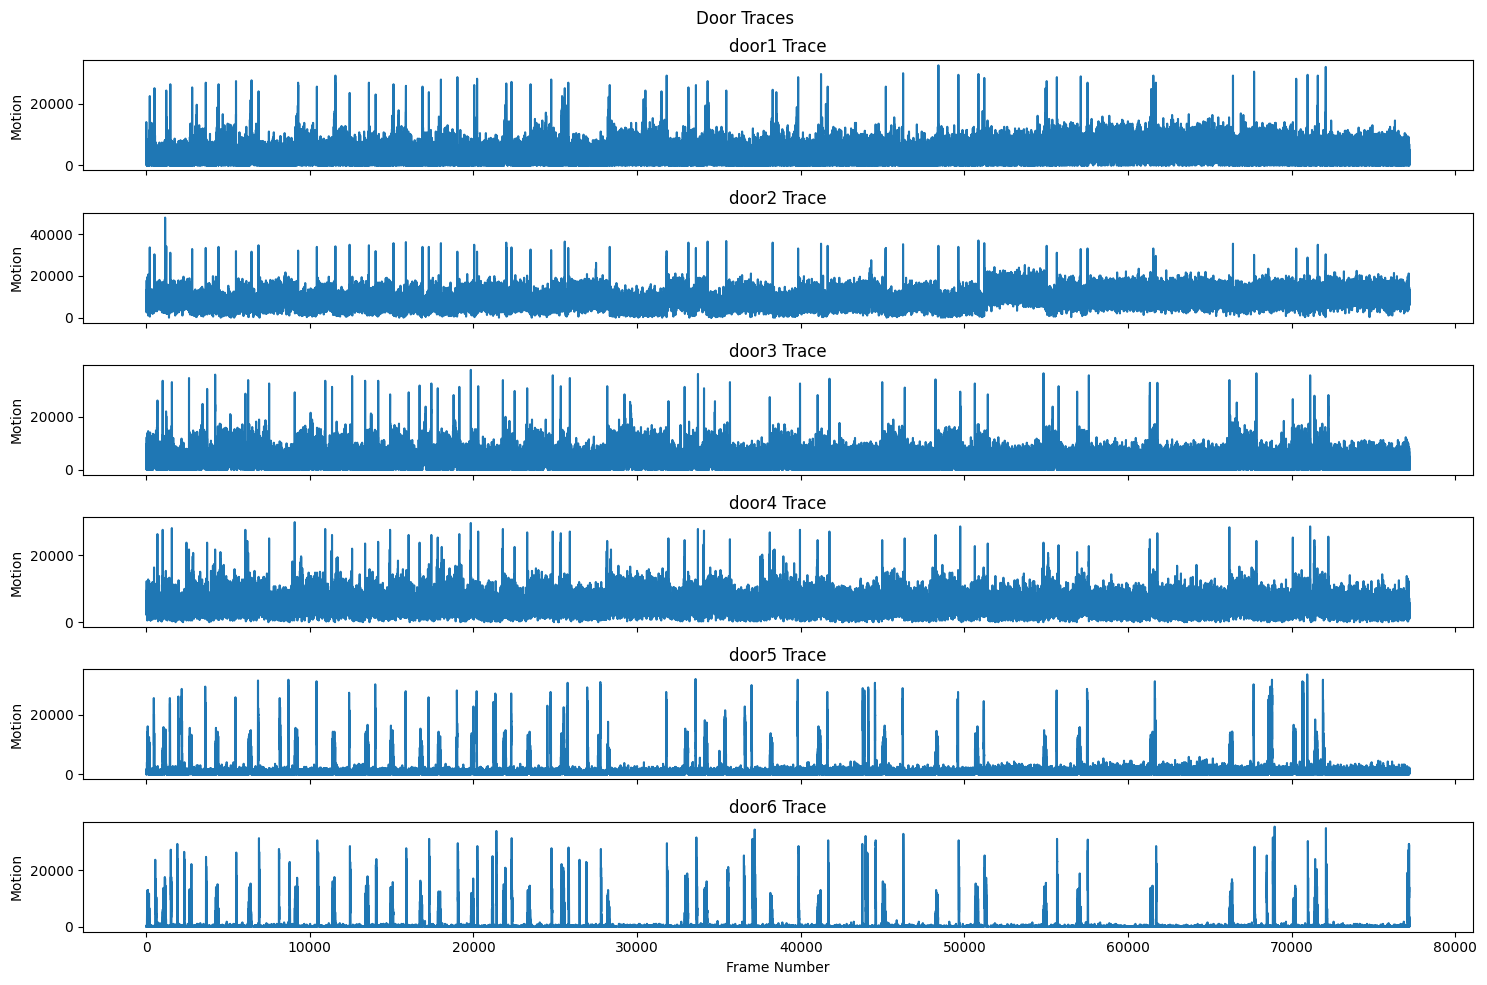

In [94]:
plotDoorTraces(dat)

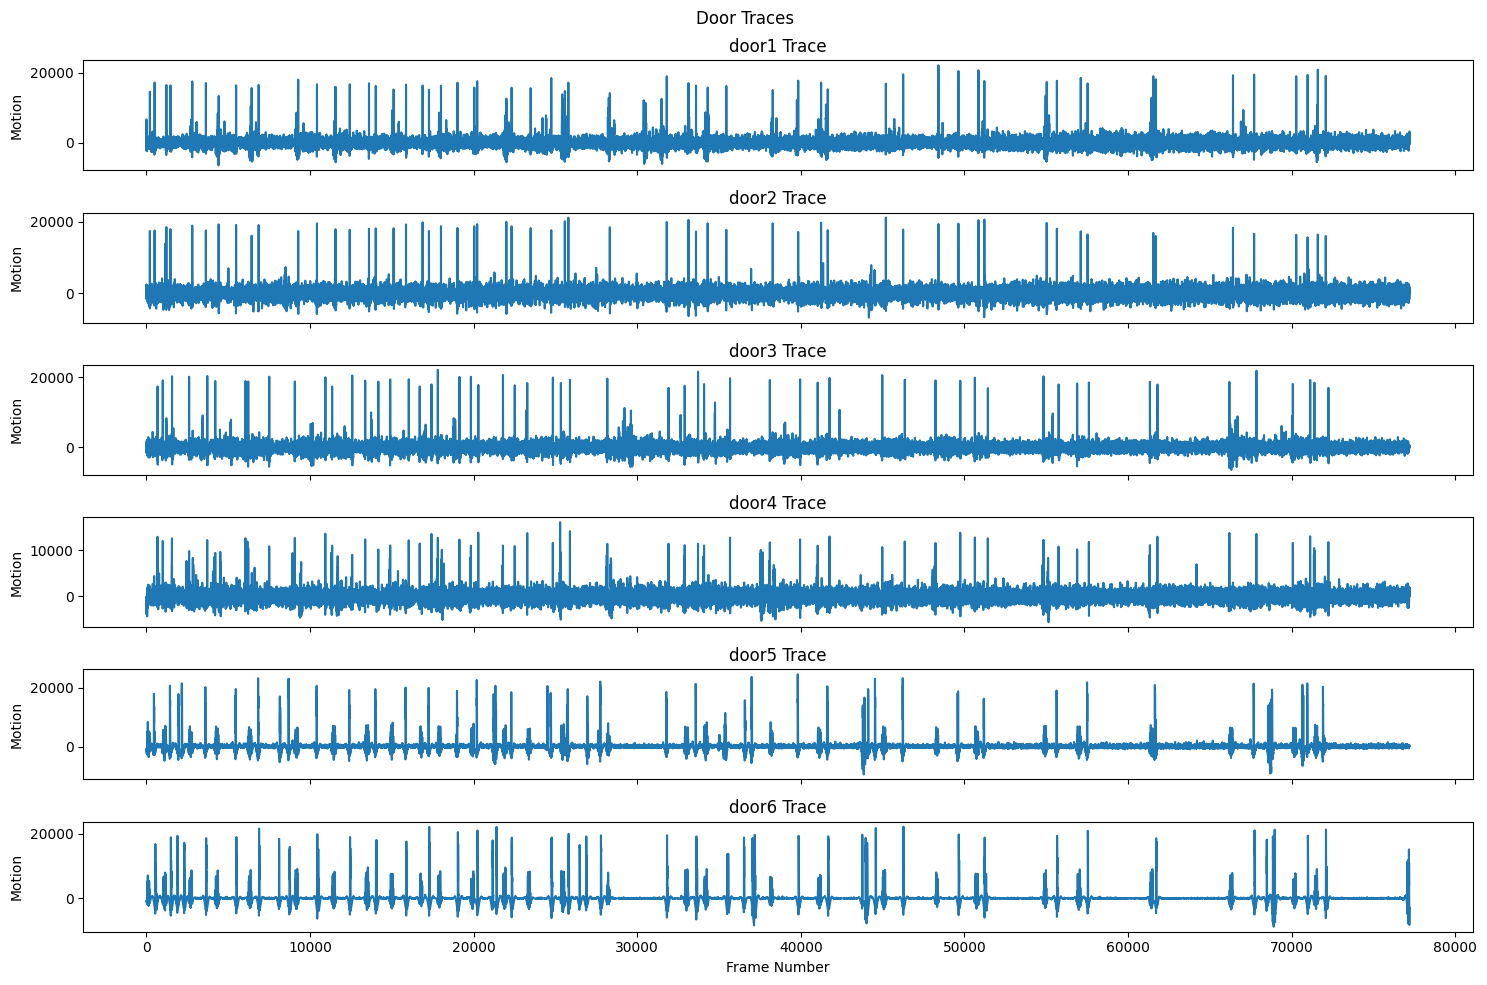

In [95]:
dat = bandpass_filter(dat)
plotDoorTraces(dat)

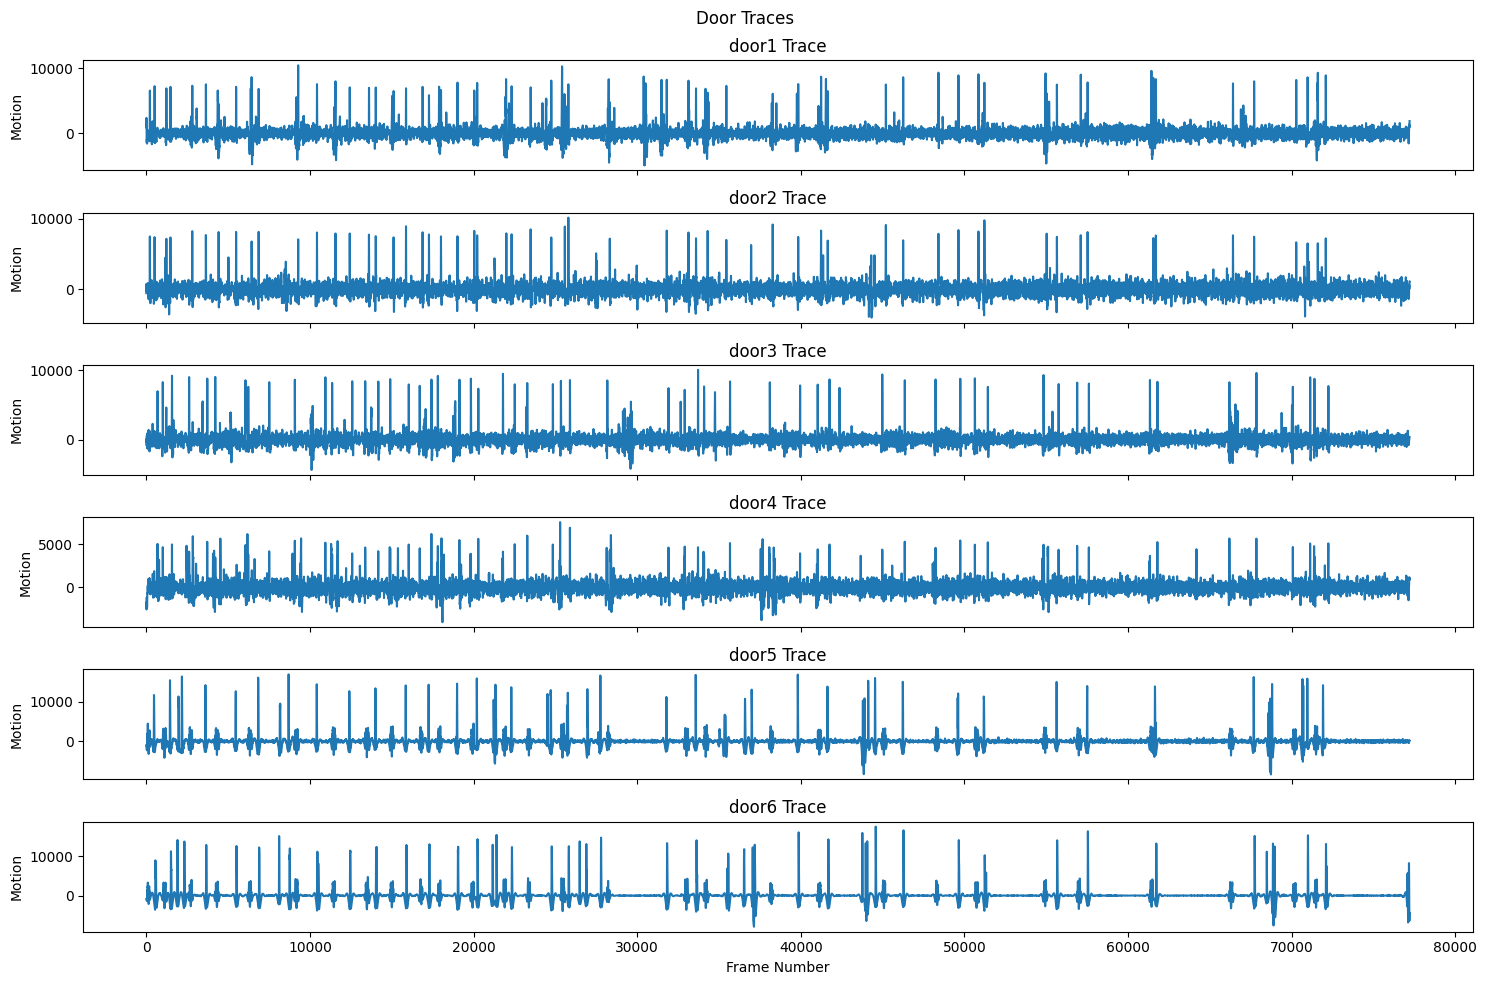

In [96]:
from scipy.ndimage import gaussian_filter1d # Smooth the door traces
for key in dat.keys():
    dat[key] = gaussian_filter1d(dat[key], sigma=5)

plotDoorTraces(dat)


Text(0.5, 0, 'Frame Number')

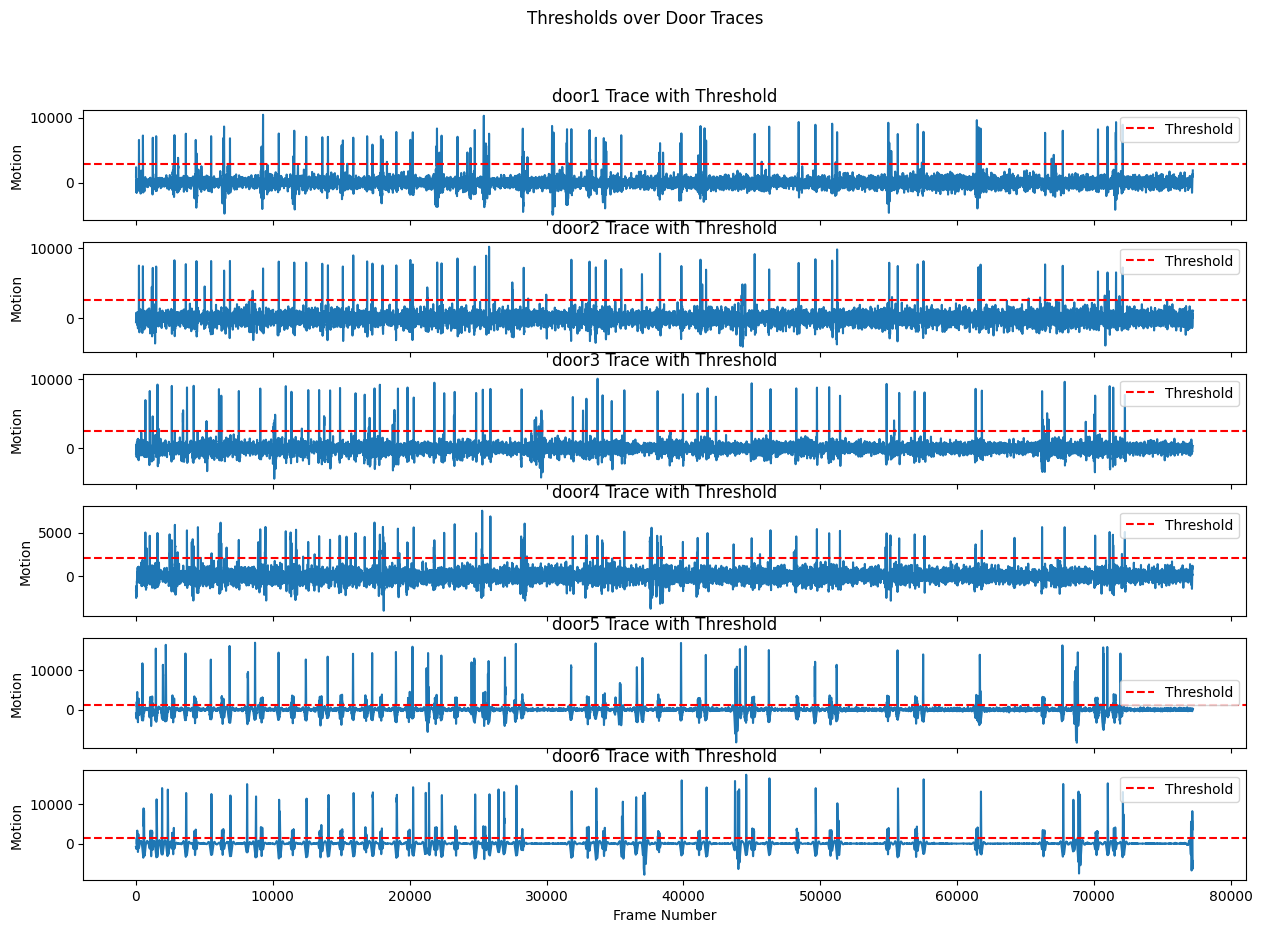

In [97]:
# Calculate thresholds based on statistics for each door
thresholds = {}
import numpy as np

for key in dat.keys():
    mean = np.mean(dat[key])
    std = np.std(dat[key])
    # Calculate mean and standard deviation of the trace
    if key == 'door5' or key == 'door6':
        n_std = .75 # This value can be adjusted to change sensitivity
    else:
        n_std = 2.5 # This value can be adjusted to change sensitivity
    #Set threshold as mean plus n standard deviations
    # Can adjust n to be more or less strict based on sensitivity needs
    
    thresholds[key] = mean + (n_std * std)

#Plot all thresholds over the traces

fig, axs = plt.subplots(6, 1, figsize=(15, 10), sharex=True)
fig.suptitle('Thresholds over Door Traces')

for i, (door, trace) in enumerate(dat.items()):
    axs[i].plot(trace)
    axs[i].axhline(thresholds[door], color='r', linestyle='--', label='Threshold')
    axs[i].set_title(f'{door} Trace with Threshold')
    axs[i].set_ylabel('Motion')
    axs[i].legend()

axs[-1].set_xlabel('Frame Number')  

Text(0.5, 0, 'Frame Number')

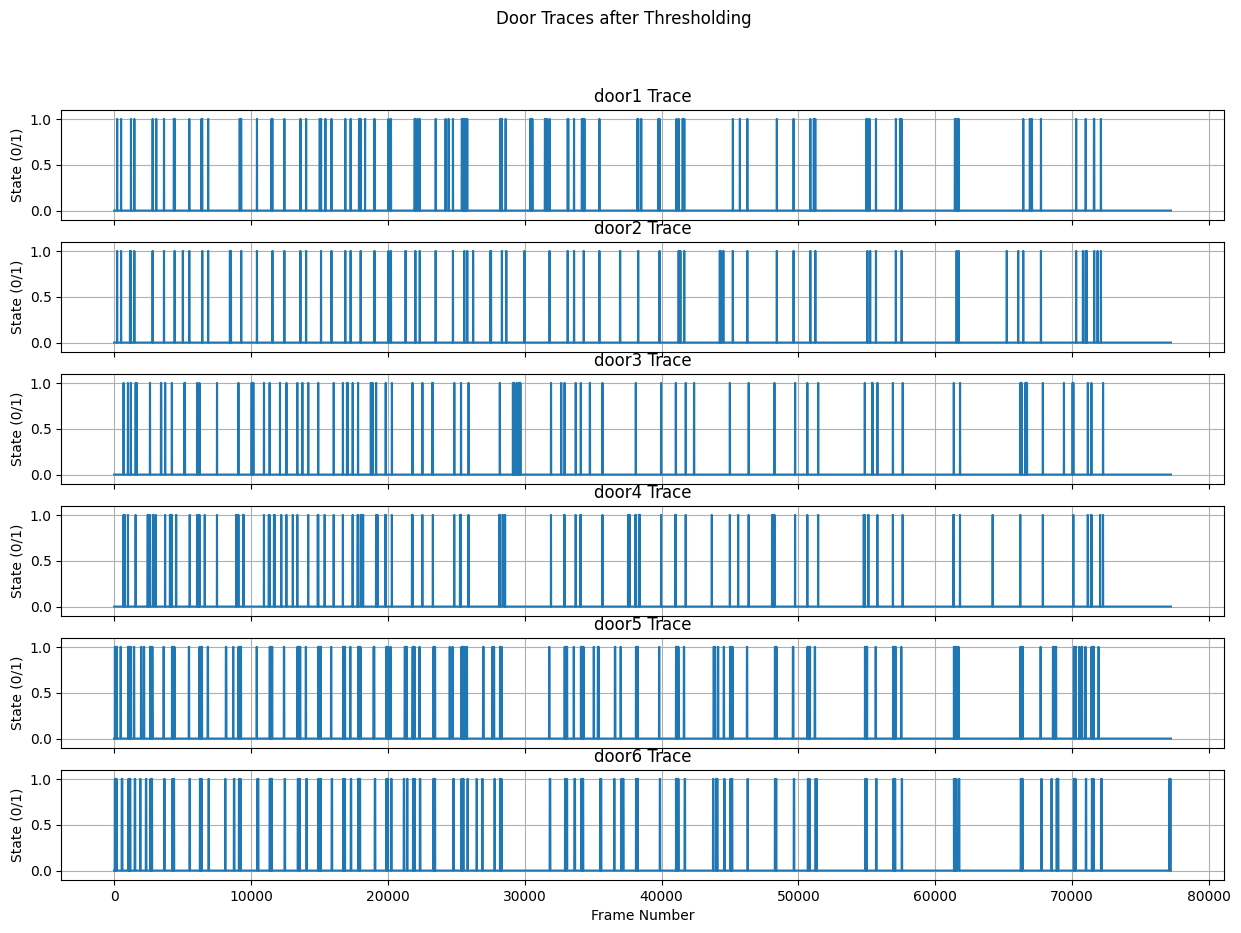

In [98]:
# Apply thresholds to all traces
for key in dat.keys():
    for i in range(len(dat[key])):
        if dat[key][i] > thresholds[key]:
            dat[key][i] = 1;
        else:
            dat[key][i] = 0;

# Plot all traces after thresholding

fig, axs = plt.subplots(6, 1, figsize=(15, 10), sharex=True)
fig.suptitle('Door Traces after Thresholding')

for i, (door, trace) in enumerate(dat.items()):
    axs[i].plot(trace)
    axs[i].set_title(f'{door} Trace')
    axs[i].set_ylabel('State (0/1)')
    axs[i].set_ylim(-0.1, 1.1)  # Set y-axis limits to better show binary data
    axs[i].grid(True)  # Add grid for better readability

axs[-1].set_xlabel('Frame Number')  

In [99]:
def pad_movement(floor, window_pad):
    for x in range(len(floor) - window_pad):
        if floor[x] == 1:
            # Search for the next 1 in the next window_pad frames
            for y in range(x + 1, x + window_pad):
                if floor[y] == 1:
                    # If a 1 is found, set all values in between to 1
                    for z in range(x + 1, y):
                        floor[z] = 1
                    break
    return floor
    


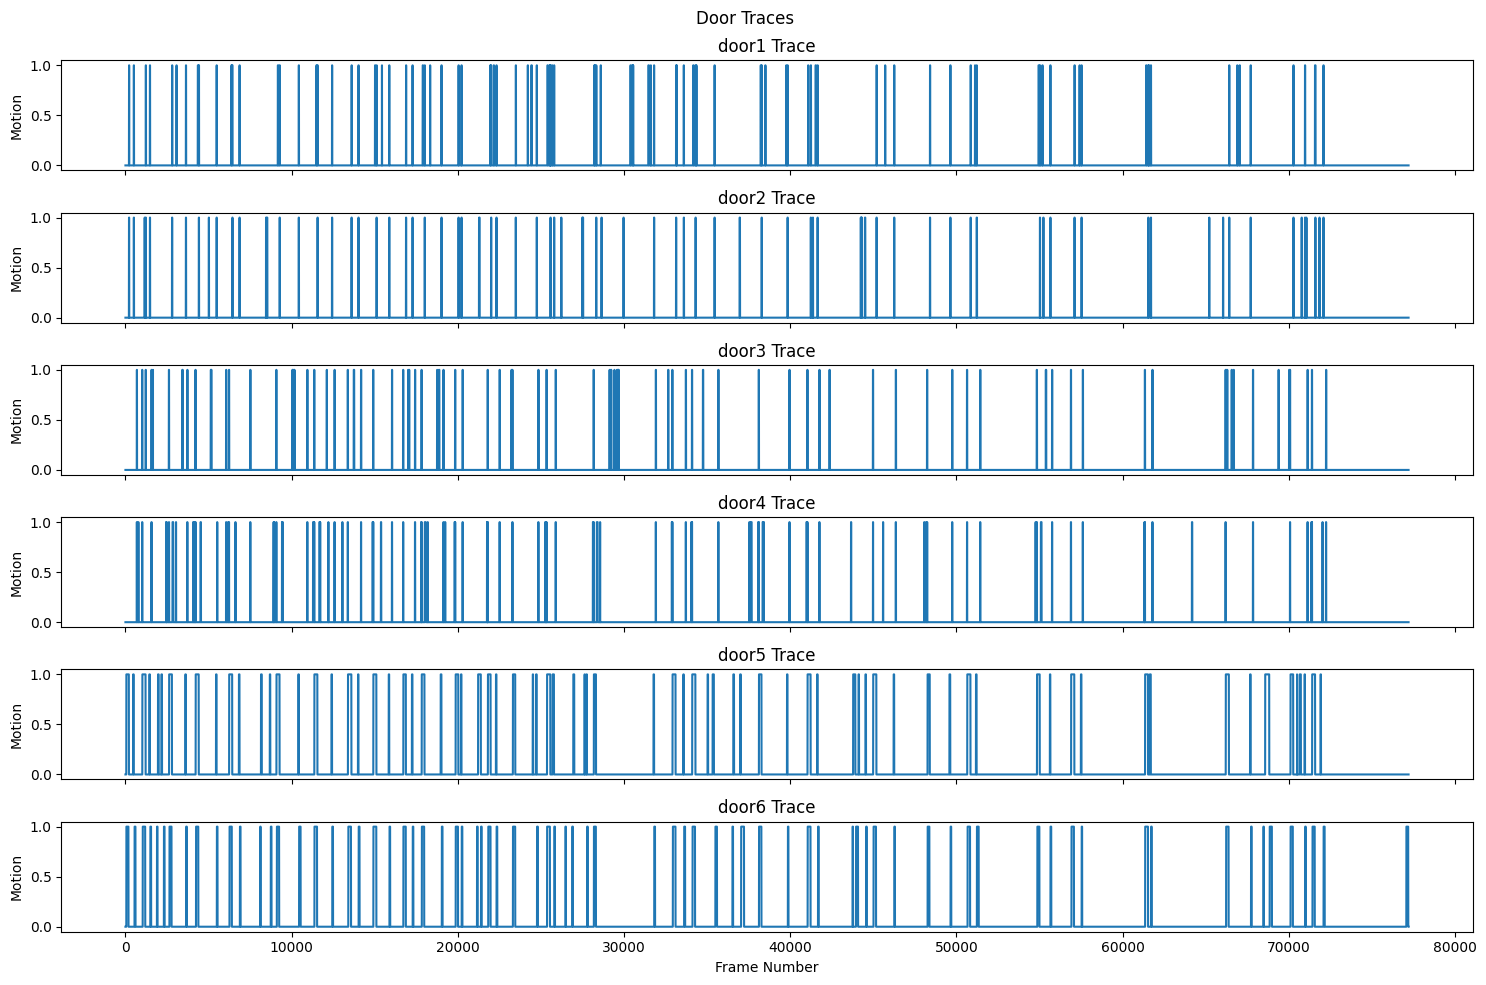

In [100]:
dat['door5'] = pad_movement(dat['door5'], 90)
dat['door6'] = pad_movement(dat['door6'], 90)

plotDoorTraces(dat)

In [ ]:
fps = 30 #Frames per second of the video
window_frames = 15 #Window size to check for concurrent movement

import pandas as pd
def find_trial_events(trace1, trace2, window_frames):
    """
    Find distinct trial events when two doors move concurrently.
    
    Args:
        trace1 (list): First door trace (binary 0/1 values)
        trace2 (list): Second door trace (binary 0/1 values)
        window_frames (int): Window size to check for concurrent movement
        
    Returns:
        List of frame indices where distinct events start
    """
    events = []  # Store frame numbers where events start
    i = 0  # Initialize frame counter
    
    # Loop through the traces, stopping window_frames before the end to prevent overflow
    while i < len(trace1) - window_frames:
        # Get a slice of frames to check for concurrent movement
        window1 = trace1[i:i+window_frames]  # Window for first door
        window2 = trace2[i:i+window_frames]  # Window for second door
        
        # Check if both doors show any movement (1's) in their windows
        if 1 in window1 and 1 in window2:
            # If both doors moved, record the start frame of this window
            events.append(i)
            # Skip ahead by the window size to avoid detecting the same event multiple times
            i += window_frames
        else:
            # If no concurrent movement, check the next frame
            i += 1
            
    return events

# Detect trial starts (when doors 1 and 2 move together)
trial_starts = find_trial_events(dat['door1'], dat['door2'], window_frames)

# Detect trial ends (when doors 3 and 4 move together)
trial_ends = find_trial_events(dat['door3'], dat['door4'], window_frames)

# Print diagnostic information
print(f"Number of trial starts found: {len(trial_starts)}")
print(f"Number of trial ends found: {len(trial_ends)}")

print("\nTrial start frames:", trial_starts)
print("\nTrial end frames:", trial_ends)

# Handle mismatched numbers of starts and ends
# If we have 5 starts but only 4 ends, we'll only use the first 4 trials
min_trials = min(len(trial_starts), len(trial_ends))
matched_starts = trial_starts[:min_trials]  # Take only complete trials
matched_ends = trial_ends[:min_trials]      # Take only complete trials

# Create a pandas DataFrame to organize the trial information
trials_df = pd.DataFrame({
    'trial_start_frame': matched_starts,     # Frame numbers where trials begin
    'trial_end_frame': matched_ends,         # Frame numbers where trials end
    'trial_start_time': [frame/fps for frame in matched_starts],  # Convert frames to seconds
    'trial_end_time': [frame/fps for frame in matched_ends]       # Convert frames to seconds
})

# Display the final results
print("\nTrial timestamps (in seconds):")
print(trials_df)

# Some logic needs to be applied to clean this up. 
# A new trial cannot start until there is an end of the previous trial.
def clean_trial_events(starts, ends, window_frames):
    """
    Clean trial events to ensure proper sequencing (start -> end -> start -> end)
    
    Args:
        starts (list): Frame numbers of potential trial starts
        ends (list): Frame numbers of potential trial ends
        window_frames (int): Window size used for detection
        
    Returns:
        tuple: Lists of cleaned trial starts and ends
    """
    cleaned_starts = []
    cleaned_ends = []
    last_end = 0
    
    i, j = 0, 0  # Indices for starts and ends lists
    
    while i < len(starts) and j < len(ends):
        current_start = starts[i]
        current_end = ends[j]

        
        # If we find a valid start (after last end) and its corresponding end
        if current_start > last_end and current_end > current_start:
            cleaned_starts.append(current_start)
            cleaned_ends.append(current_end)
            last_end = current_end
            i += 1
            j += 1
        # Skip invalid starts (before last end)
        elif current_start <= last_end:
            i += 1
        # Skip ends that come before their start
        elif current_end <= current_start:
            j += 1

    while i < len(starts) and j < len(ends):
        current_start = starts[i]
        current_end = ends[j]
            
    return cleaned_starts, cleaned_ends

# Clean the trial events
cleaned_starts, cleaned_ends = clean_trial_events(trial_starts, trial_ends, window_frames)

# Create updated DataFrame with cleaned trials
cleaned_trials_df = pd.DataFrame({
    'trial_start_frame': cleaned_starts,
    'trial_end_frame': cleaned_ends,
    'trial_start_time': [frame/fps for frame in cleaned_starts],
    'trial_end_time': [frame/fps for frame in cleaned_ends],
    'trial_duration': [(end - start)/fps for start, end in zip(cleaned_starts, cleaned_ends)]
})

print("\nCleaned trial timestamps (in seconds):")
print(cleaned_trials_df)


Number of trial starts found: 117
Number of trial ends found: 114

Trial start frames: [198, 213, 486, 501, 1207, 1222, 1454, 1469, 2791, 2806, 3621, 3636, 4406, 4421, 5469, 5484, 6416, 6431, 6847, 6862, 9261, 9276, 10412, 10427, 11540, 11555, 12414, 12429, 13592, 13607, 14004, 14019, 15095, 15110, 15853, 15868, 16867, 16882, 17257, 17272, 17992, 18007, 18999, 19014, 20027, 20042, 20203, 20218, 21985, 22000, 22306, 22321, 23472, 23487, 24731, 24746, 25557, 25572, 25587, 25775, 25790, 28312, 28327, 31789, 31804, 33117, 33132, 33579, 33594, 34293, 34308, 35431, 35446, 38269, 38284, 39825, 39840, 41222, 41237, 41632, 41647, 45183, 45198, 46239, 46254, 48395, 48410, 49617, 49632, 50841, 50856, 51202, 51217, 55014, 55029, 55636, 55651, 57092, 57107, 57513, 57528, 61529, 61544, 61686, 61701, 66398, 66413, 67691, 67706, 70264, 70279, 70959, 70974, 71581, 71596, 72069, 72084]

Trial end frames: [668, 683, 987, 1002, 1548, 1563, 2598, 2613, 3705, 3720, 4197, 4212, 6039, 6054, 6212, 6227, 7494, 

In [122]:
print(cleaned_trials_df)

    trial_start_frame  trial_end_frame  trial_start_time  trial_end_time  \
0                 198              668          6.600000       22.266667   
1                1207             1548         40.233333       51.600000   
2                2791             3705         93.033333      123.500000   
3                4406             6039        146.866667      201.300000   
4                6416             7494        213.866667      249.800000   
5                9261            10923        308.700000      364.100000   
6               11540            12565        384.666667      418.833333   
7               13592            14156        453.066667      471.866667   
8               15095            16021        503.166667      534.033333   
9               16867            17407        562.233333      580.233333   
10              17992            19117        599.733333      637.233333   
11              20027            20272        667.566667      675.733333   
12          

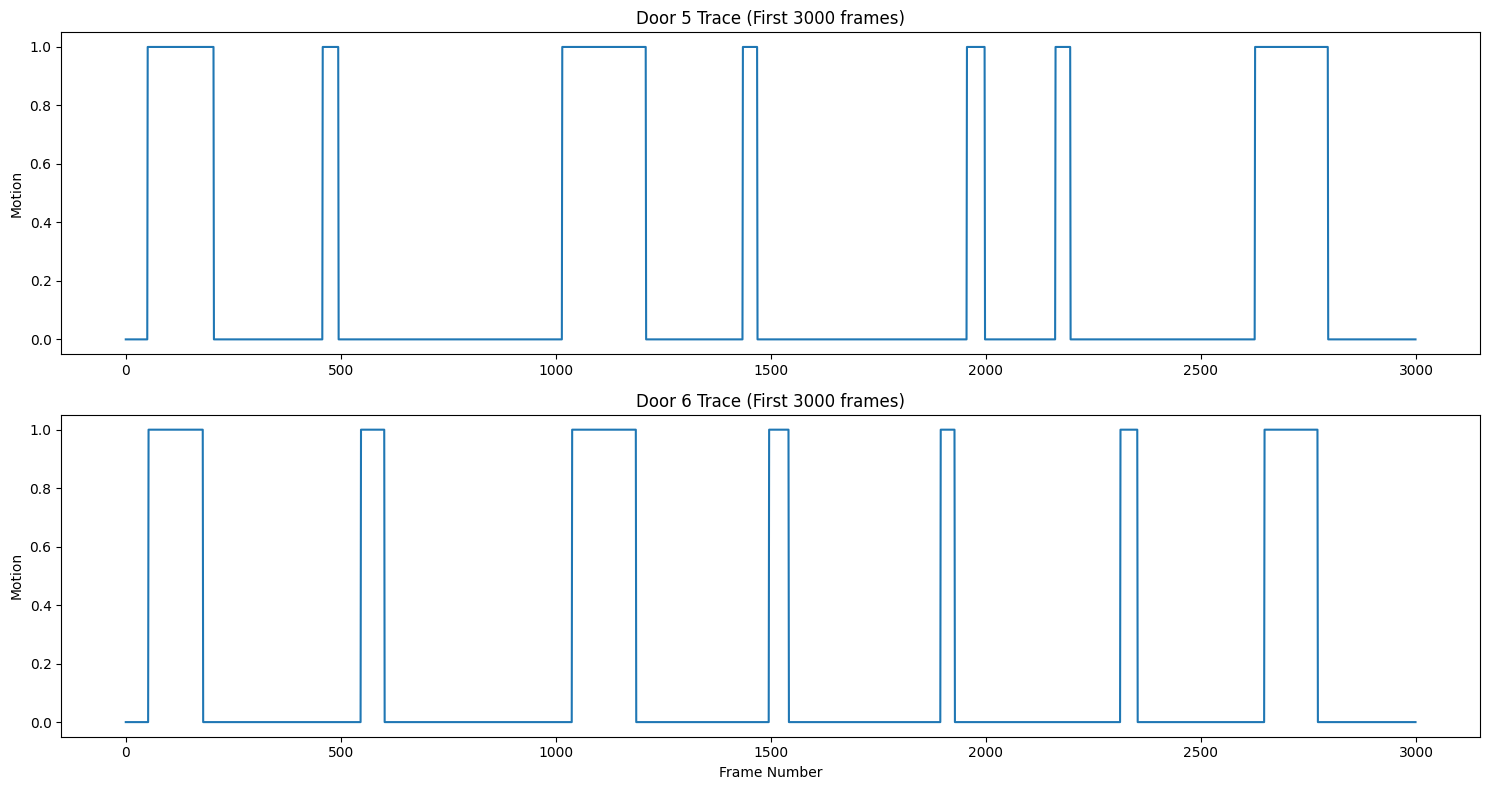

In [110]:
subset_data = {
    'door5': dat['door5'][:3000],
    'door6': dat['door6'][:3000]
}

# Plot just these two doors
plt.figure(figsize=(15, 8))

# Plot door5
plt.subplot(2, 1, 1)
plt.plot(subset_data['door5'])
plt.title('Door 5 Trace (First 3000 frames)')
plt.ylabel('Motion')

# Plot door6
plt.subplot(2, 1, 2)
plt.plot(subset_data['door6'])
plt.title('Door 6 Trace (First 3000 frames)')
plt.ylabel('Motion')
plt.xlabel('Frame Number')

plt.tight_layout()
plt.show()

In [113]:
def extract_floor_traces(dat):
    floor1 = dat['door5']
    floor2 = dat['door6']
    floor_traces = []

    # Add floor1 [x] to floor2 [x]
    for x in range(len(floor1)):
        floor_traces.append(floor1[x] + floor2[x])
    
    floor_starts = []
    floor_ends = []
    isMoving = False
    for x in range(len(floor_traces)):
        if floor_traces[x] == 2:
            if isMoving == False:
                floor_starts.append(x)
                isMoving = True
        if floor_traces[x] < 2:
            if isMoving == True:
                floor_ends.append(x)
                isMoving = False
    
    return floor_starts, floor_ends
floorStarts, floorEnds = extract_floor_traces(dat)

print(floorStarts)  
print(floorEnds)


[53, 1038, 2648, 4246, 6261, 9110, 11372, 13410, 14918, 16723, 17834, 19872, 21831, 23315, 25370, 28187, 32938, 34123, 38122, 41050, 45015, 48269, 50673, 54871, 56925, 61358, 66231, 70108, 71428]
[180, 1187, 2772, 4383, 6399, 9246, 11528, 13570, 15095, 16868, 17974, 20009, 21968, 23452, 25540, 28308, 33097, 34272, 38267, 41222, 45163, 48375, 50822, 54994, 57073, 61529, 66379, 70245, 71562]


In [117]:
print(len(floorStarts))
print(len(floorEnds))

floors_trials_df = pd.DataFrame({
    'trial_start_frame': floorStarts,
    'trial_end_frame': floorEnds,
    'trial_start_time': [frame/fps for frame in floorStarts],
    'trial_end_time': [frame/fps for frame in floorEnds],
    'trial_duration': [(end - start)/fps for start, end in zip(floorStarts, floorEnds)]
})

print(floors_trials_df)

29
29
    trial_start_frame  trial_end_frame  trial_start_time  trial_end_time  \
0                  53              180          1.766667        6.000000   
1                1038             1187         34.600000       39.566667   
2                2648             2772         88.266667       92.400000   
3                4246             4383        141.533333      146.100000   
4                6261             6399        208.700000      213.300000   
5                9110             9246        303.666667      308.200000   
6               11372            11528        379.066667      384.266667   
7               13410            13570        447.000000      452.333333   
8               14918            15095        497.266667      503.166667   
9               16723            16868        557.433333      562.266667   
10              17834            17974        594.466667      599.133333   
11              19872            20009        662.400000      666.966667   
12    

In [ ]:
from tmaze_toolkit.visualization.videoTools import visualize_video_with_stamps

video_path = r"C:\Users\rlampre\Desktop\t-maze-Custer-Liu\Example Videos\BDY5_2024-07-01T19_24_56.mp4"
visualize_video_with_stamps(video_path, cleaned_trials_df)


In [118]:
visualize_video_with_stamps(video_path, floors_trials_df)

Stamped video saved to C:\Users\rlampre\Desktop\t-maze-Custer-Liu\Example Videos\BDY5_2024-07-01T19_24_56_stamped.mp4


In [121]:
# compare cleaned_trials_df and floors_trials_df 
# find row numbers where trial_end_frame of floors_trials_df is not within 30 frames trial_start_frame of cleaned_trials_df

# find the row numbers where the difference between trial_end_frame and trial_start_frame is greater than 30
for i in range(len(floors_trials_df)):
    if abs(floors_trials_df['trial_end_frame'][i] - cleaned_trials_df['trial_start_frame'][i]) > 30:
        print(i)

print(cleaned_trials_df.shape)
print(floors_trials_df.shape)



(29, 5)
(29, 5)
